## Polish stock market indices analysis

In [1]:
# I begin with some standard imports
import math
import os
import sys
import time
import numpy as np
import pandas as pd
import quantstats as qs
import random as rn
import matplotlib.pyplot as plt
import scipy.stats as scs
%matplotlib inline
%config InLineBackend.figure_format = 'svg'

In [2]:
# To suppress some warnings
import warnings
warnings.simplefilter('ignore')

In [3]:
# Sci-kit learn imports (for shallow learning)
import sklearn
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 

In [4]:
# Tensorflow and Keras imports (for deep learning)
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.initializers import random_normal
from keras.layers import Dense, Dropout, SimpleRNN, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

In [5]:
# Some Matplotlib and Seaborn settings to standardize the figures in the notebook 
plt.rcParams["figure.dpi"] = 75
plt.style.use("seaborn-v0_8")

In [6]:
# I define a seed function to set all seeds (starting values for Random Number Generator) for future reproducibility
def set_seeds(seed=100):
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

In [7]:
# To setup a function and a destination folder to save the models
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figures", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Before moving on I check the current versions of tech stack/libraries installed/utilized
print("Python version: ", sys.version[:5])
print("Scikit-learn version: ", sklearn.__version__)
print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)

Python version:  3.8.3
Scikit-learn version:  1.3.2
Keras version:  2.10.0
Tensorflow version:  2.10.0


## Exploratory Data Analysis (EDA)

In [8]:
# Import raw data from a CSV file obtained from InfoStrefa database for 4 main Polish equity market indices
# Set first columns as index columns
# Convert the date (string) columns to a DatetimeIndex columns
raw = pd.read_csv('WIG.csv', index_col=0, parse_dates=True)

wig = pd.read_csv('WIG.csv', index_col=0, parse_dates=True)
wig20 = pd.read_csv('WIG20.csv', index_col=0, parse_dates=True)
mwig40 = pd.read_csv('mWIG40.csv', index_col=0, parse_dates=True)
swig80 = pd.read_csv('sWIG80.csv', index_col=0, parse_dates=True)

In [9]:
# Let's inspect:
# 1. Metadata (info() method)
# 2. Data (tail() method)
# 3. Baisc statistics (describe() method, below for wig20 index only)

In [10]:
wig20.info()
wig20.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7399 entries, 1994-04-18 to 2023-12-29
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_wig20   7399 non-null   float64
 1   high_wig20   7399 non-null   float64
 2   low_wig20    7399 non-null   float64
 3   close_wig20  7399 non-null   float64
dtypes: float64(4)
memory usage: 289.0 KB


,open_wig20,high_wig20,low_wig20,close_wig20
Data,,,,
2023-12-21,2333.32,2355.14,2329.78,2348.67
2023-12-22,2345.16,2353.47,2338.03,2346.70
2023-12-27,2348.85,2378.32,2348.85,2371.28
2023-12-28,2374.38,2380.55,2356.32,2356.32
2023-12-29,2356.84,2367.01,2334.30,2342.99


In [11]:
wig20.describe().round(2)

,open_wig20,high_wig20,low_wig20,close_wig20
count,7399.00,7399.00,7399.00,7399.00
mean,1994.83,2010.19,1978.30,1994.45
std,617.82,622.53,611.55,617.21
min,577.90,577.90,577.90,577.90
25%,1583.18,1598.26,1568.66,1582.80
50%,2003.90,2020.04,1983.44,2000.90
75%,2371.74,2387.70,2354.78,2370.56
max,3935.47,3940.53,3910.96,3917.87


In [12]:
mwig40.info()
mwig40.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6509 entries, 1997-12-31 to 2023-12-29
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open_mwig40   6509 non-null   float64
 1   high_mwig40   6509 non-null   float64
 2   low_mwig40    6509 non-null   float64
 3   close_mwig40  6509 non-null   float64
dtypes: float64(4)
memory usage: 254.3 KB


,open_mwig40,high_mwig40,low_mwig40,close_mwig40
Data,,,,
2023-12-21,5876.86,5880.79,5833.93,5880.79
2023-12-22,5874.07,5876.90,5844.89,5864.68
2023-12-27,5872.31,5883.49,5842.38,5847.11
2023-12-28,5849.55,5875.54,5836.06,5845.89
2023-12-29,5848.65,5853.96,5760.91,5785.21


In [13]:
swig80.info()
swig80.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7257 entries, 1994-12-29 to 2023-12-29
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open_swig80   7257 non-null   float64
 1   high_swig80   7257 non-null   float64
 2   low_swig80    7257 non-null   float64
 3   close_swig80  7257 non-null   float64
dtypes: float64(4)
memory usage: 283.5 KB


,open_swig80,high_swig80,low_swig80,close_swig80
Data,,,,
2023-12-21,22627.12,22644.29,22520.92,22596.17
2023-12-22,22592.39,22705.37,22586.68,22674.27
2023-12-27,22758.07,22858.09,22758.07,22802.65
2023-12-28,22867.93,22950.33,22867.67,22950.33
2023-12-29,22975.52,23059.90,22869.68,22904.49


In [14]:
wig.info()
wig.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7732 entries, 1991-04-16 to 2023-12-29
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open_wig   7732 non-null   float64
 1   high_wig   7732 non-null   float64
 2   low_wig    7732 non-null   float64
 3   close_wig  7732 non-null   float64
dtypes: float64(4)
memory usage: 302.0 KB


,open_wig,high_wig,low_wig,close_wig
Data,,,,
2023-12-21,78341.36,78840.93,78237.66,78723.40
2023-12-22,78560.60,78814.86,78409.07,78667.79
2023-12-27,78916.60,79460.94,78784.47,79246.98
2023-12-28,79451.43,79548.69,78935.53,78937.48
2023-12-29,78961.91,79159.47,78202.60,78459.91


In [15]:
# The data looks good 
# 1. No null values (datasets are complete)
# 2. Date columns are of the DatetimeIndex type (reliable future timeseries data manipulation)
# 3. The numerical data is of float64 type (good because....)

In [16]:
# Let's merge the 4 obtained datasets into one dataset
# First, inspect the datasets shapes
wig.shape, wig20.shape, mwig40.shape, swig80.shape

((7732, 4), (7399, 4), (6509, 4), (7257, 4))

In [17]:
# Second, combine 4 datasets with outer joins (to have all 4 datasets in a single dataset, no data lost in the process)
data_merged = pd.merge(wig, wig20, how="outer", left_index=True, right_index=True)
data_merged = pd.merge(data_merged, mwig40, how="outer", left_index=True, right_index=True)
data_merged = pd.merge(data_merged, swig80, how="outer", left_index=True, right_index=True)
data_merged

,open_wig,high_wig,low_wig,close_wig,open_wig20,high_wig20,low_wig20,close_wig20,open_mwig40,high_mwig40,low_mwig40,close_mwig40,open_swig80,high_swig80,low_swig80,close_swig80
Data,,,,,,,,,,,,,,,,
1991-04-16,1000.00,1000.00,1000.00,1000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-23,967.70,967.70,967.70,967.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,945.60,945.60,945.60,945.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-14,939.60,939.60,939.60,939.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-21,966.10,966.10,966.10,966.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,78341.36,78840.93,78237.66,78723.40,2333.32,2355.14,2329.78,2348.67,5876.86,5880.79,5833.93,5880.79,22627.12,22644.29,22520.92,22596.17
2023-12-22,78560.60,78814.86,78409.07,78667.79,2345.16,2353.47,2338.03,2346.70,5874.07,5876.90,5844.89,5864.68,22592.39,22705.37,22586.68,22674.27
2023-12-27,78916.60,79460.94,78784.47,79246.98,2348.85,2378.32,2348.85,2371.28,5872.31,5883.49,5842.38,5847.11,22758.07,22858.09,22758.07,22802.65


In [18]:
# Thrid, check the shape of the combined dataset
data_merged.shape

(7732, 16)

In [19]:
# Let's create a DataFrame object out of the merged data and inspect it
df = pd.DataFrame(data_merged)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7732 entries, 1991-04-16 to 2023-12-29
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open_wig      7732 non-null   float64
 1   high_wig      7732 non-null   float64
 2   low_wig       7732 non-null   float64
 3   close_wig     7732 non-null   float64
 4   open_wig20    7399 non-null   float64
 5   high_wig20    7399 non-null   float64
 6   low_wig20     7399 non-null   float64
 7   close_wig20   7399 non-null   float64
 8   open_mwig40   6509 non-null   float64
 9   high_mwig40   6509 non-null   float64
 10  low_mwig40    6509 non-null   float64
 11  close_mwig40  6509 non-null   float64
 12  open_swig80   7257 non-null   float64
 13  high_swig80   7257 non-null   float64
 14  low_swig80    7257 non-null   float64
 15  close_swig80  7257 non-null   float64
dtypes: float64(16)
memory usage: 1.0 MB


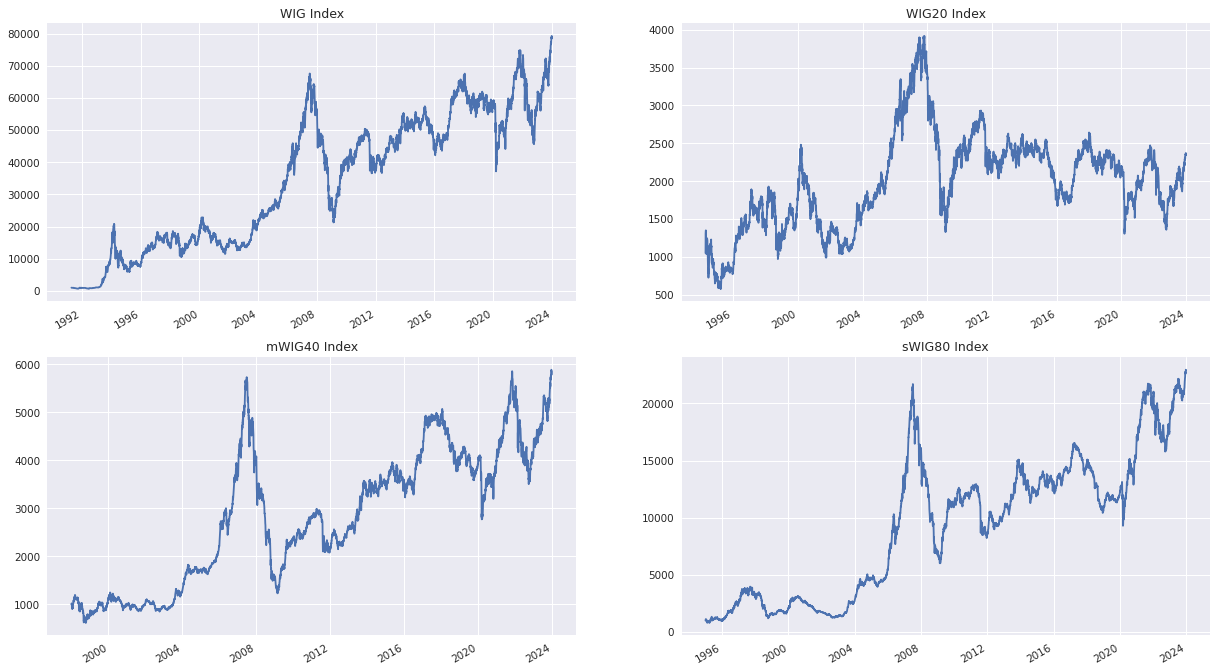

In [20]:
# Let's visualise some index level plots
# Prepare a canvas
# Add some titles
# Do some housekeeping
# Plot index closing levels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
ax11 = axes[0][0]
ax12 = axes[0][1]
ax21 = axes[1][0]
ax22 = axes[1][1]
ax11.title.set_text('WIG Index')
ax12.title.set_text('WIG20 Index')
ax21.title.set_text('mWIG40 Index')
ax22.title.set_text('sWIG80 Index')
df['close_wig'].plot(ax=ax11)
df['close_wig20'].plot(ax=ax12)
df['close_mwig40'].plot(ax=ax21)
df['close_swig80'].plot(ax=ax22)
ax11.set(xlabel=None)
ax12.set(xlabel=None)
ax21.set(xlabel=None)
ax22.set(xlabel=None);

In [21]:
# Let's calculate the relative strength of Polish equity indices since 2000 (based on daily log returns)
df1 = df.copy()
df1['wig_r'] = np.log(df1['close_wig'] / df1['close_wig'].shift(1))
df1['wig20_r'] = np.log(df1['close_wig20'] / df1['close_wig20'].shift(1))
df1['mwig40_r'] = np.log(df1['close_mwig40'] / df1['close_mwig40'].shift(1))
df1['swig80_r'] = np.log(df1['close_swig80'] / df1['close_swig80'].shift(1))
df1.dropna(inplace=True)
df1[['wig20_r', 'wig_r', 'mwig40_r', 'swig80_r']].loc['2000-01-01':].sum().apply(np.exp)

wig20_r      1.309958
wig_r        4.338733
mwig40_r     5.189460
swig80_r    10.980627
dtype: float64

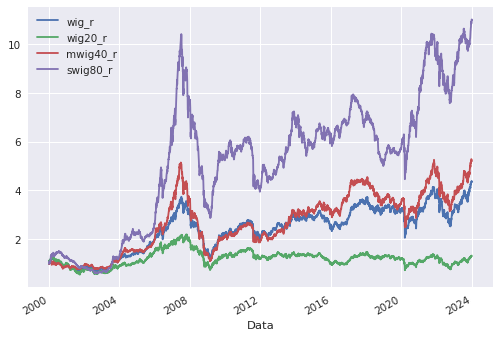

In [22]:
# Plot the relative strength
df1[['wig_r', 'wig20_r', 'mwig40_r', 'swig80_r']].loc['2000-01-01':].cumsum().apply(np.exp).plot();

## Further EDA analysis

## WIG Index

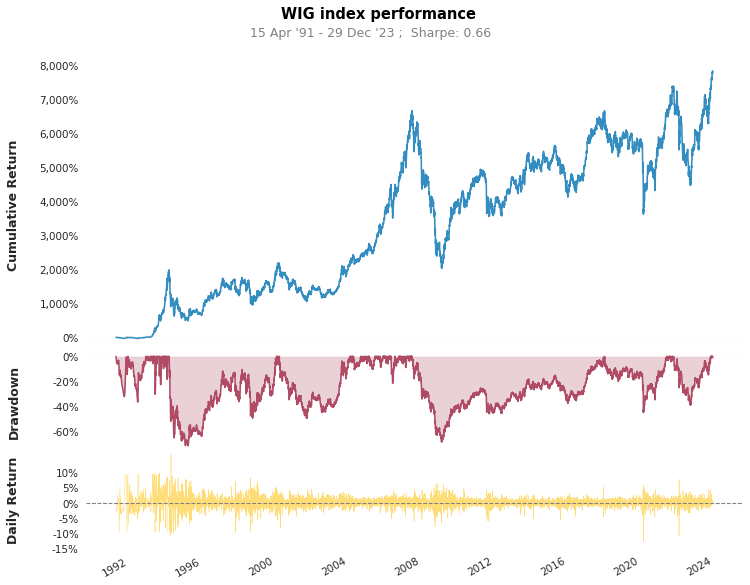

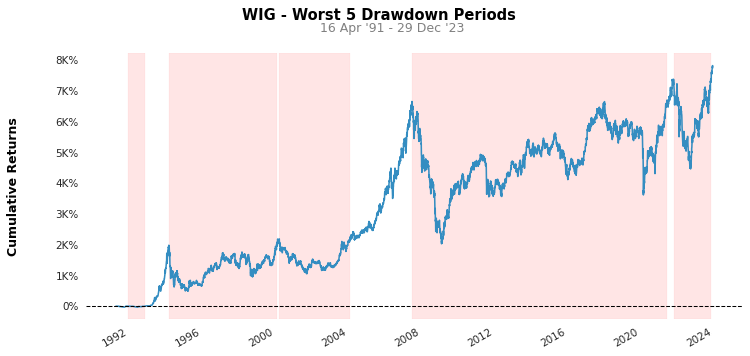

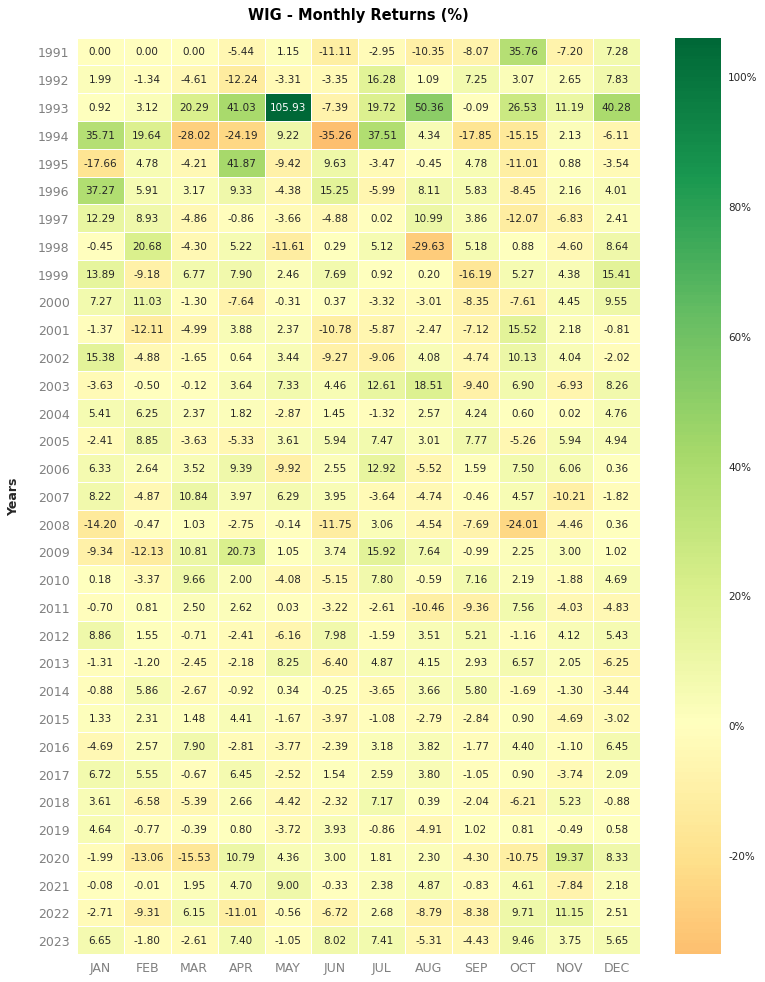

In [23]:
qs.plots.snapshot(df['close_wig'], title='WIG index performance', fontname='sans-serif')
qs.plots.drawdowns_periods(df['close_wig'], title='WIG', fontname='sans-serif')
qs.plots.monthly_heatmap(df['close_wig'], fontname='sans-serif', returns_label='WIG')

## WIG20 Index

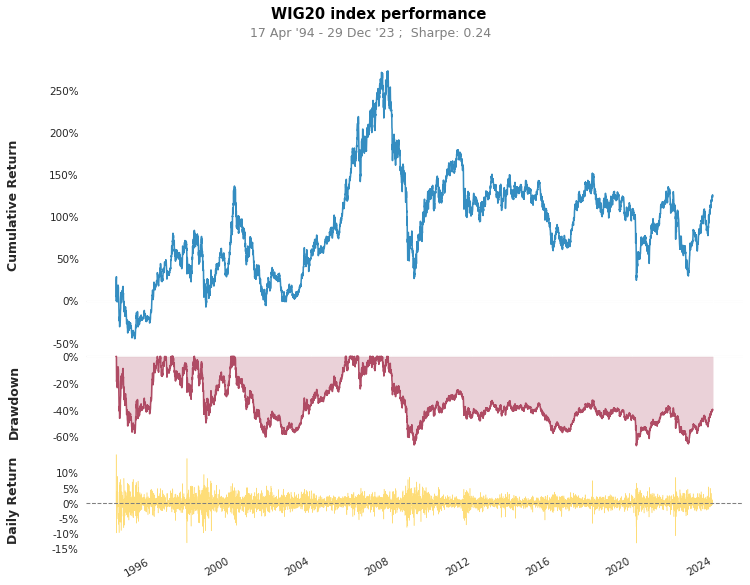

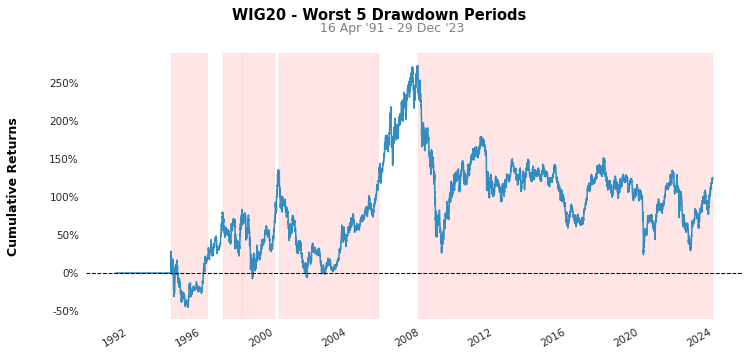

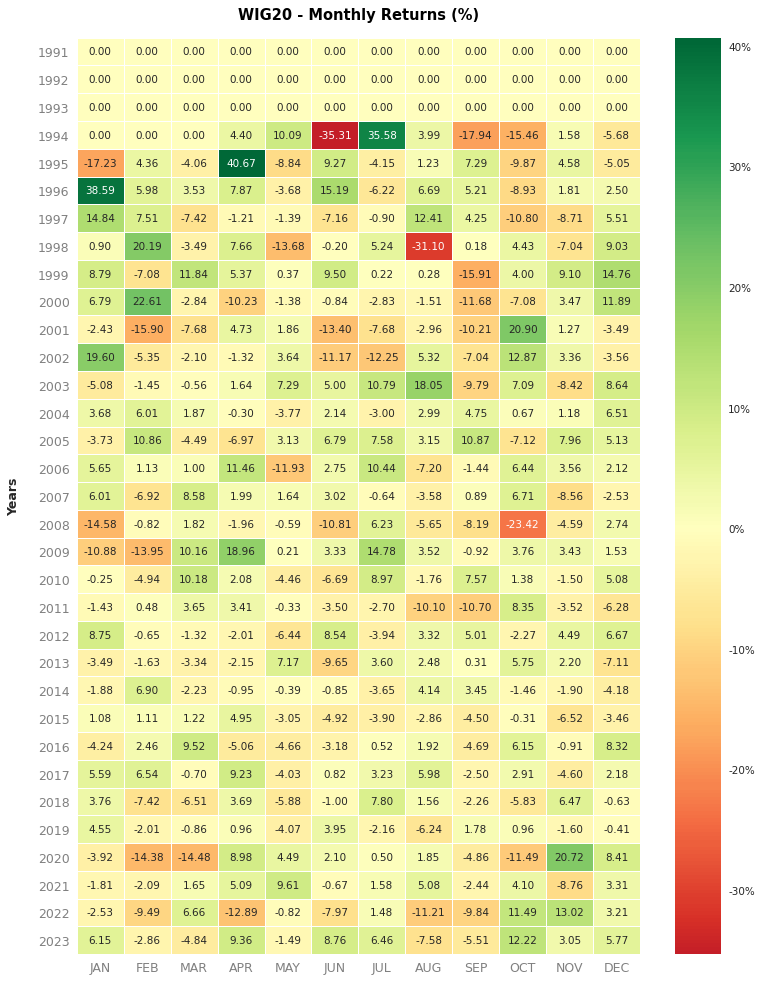

In [24]:
qs.plots.snapshot(df['close_wig20'], title='WIG20 index performance', fontname='sans-serif')
qs.plots.drawdowns_periods(df['close_wig20'], title='WIG20', fontname='sans-serif')
qs.plots.monthly_heatmap(df['close_wig20'], fontname='sans-serif', returns_label='WIG20')

## mWIG40 Index

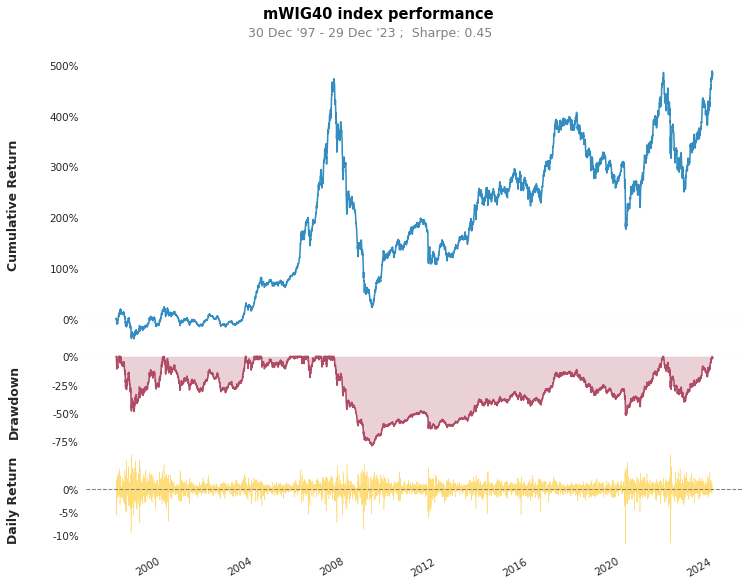

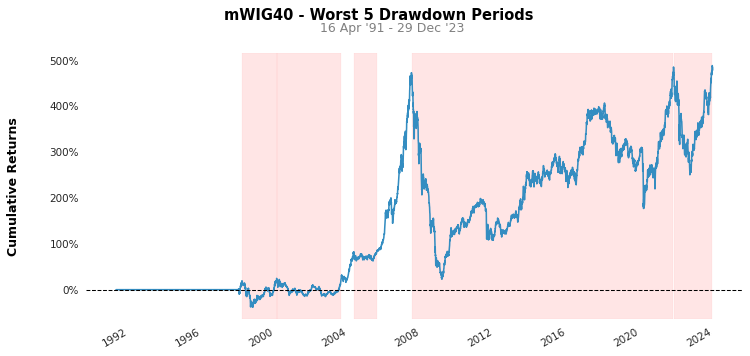

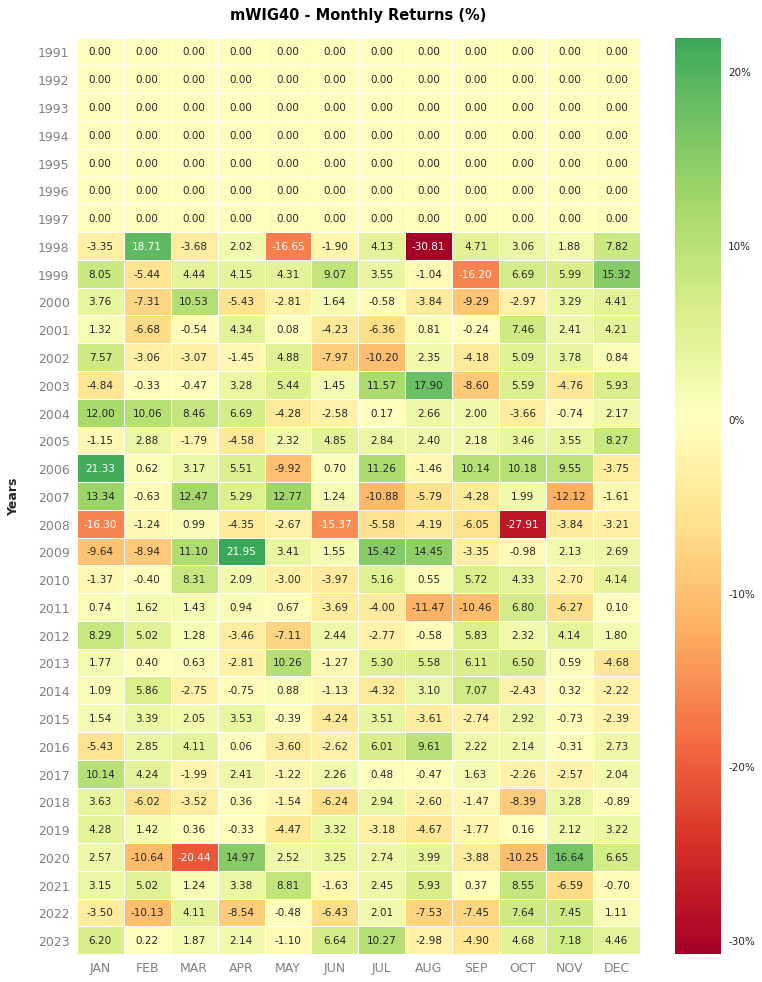

In [25]:
qs.plots.snapshot(df['close_mwig40'], title='mWIG40 index performance', fontname='sans-serif')
qs.plots.drawdowns_periods(df['close_mwig40'], title='mWIG40', fontname='sans-serif')
qs.plots.monthly_heatmap(df['close_mwig40'], fontname='sans-serif', returns_label='mWIG40')

## sWIG80 Index

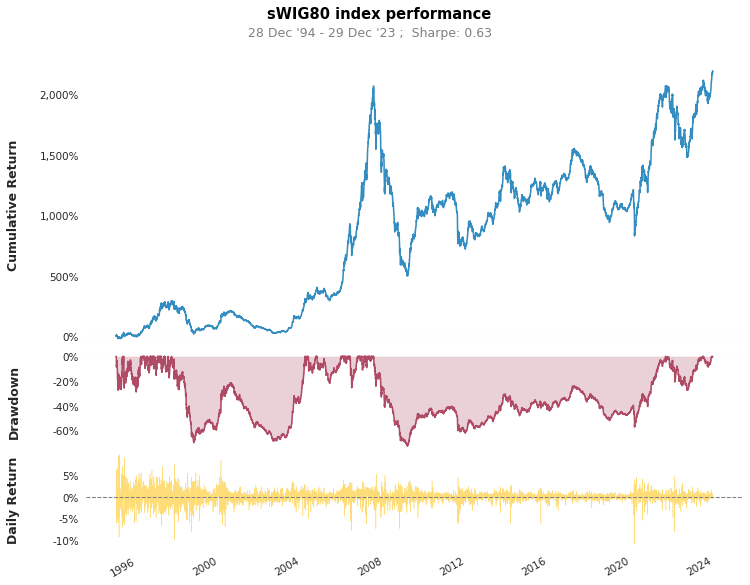

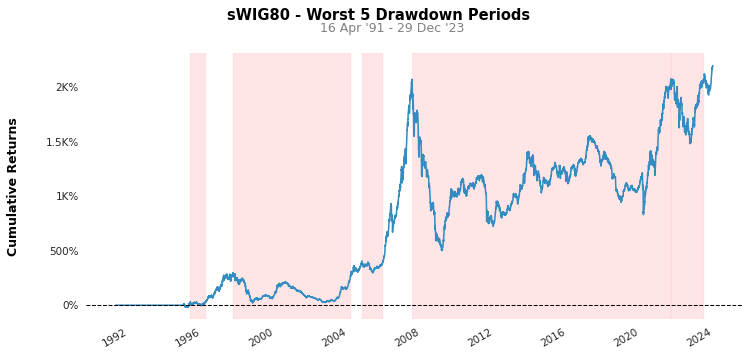

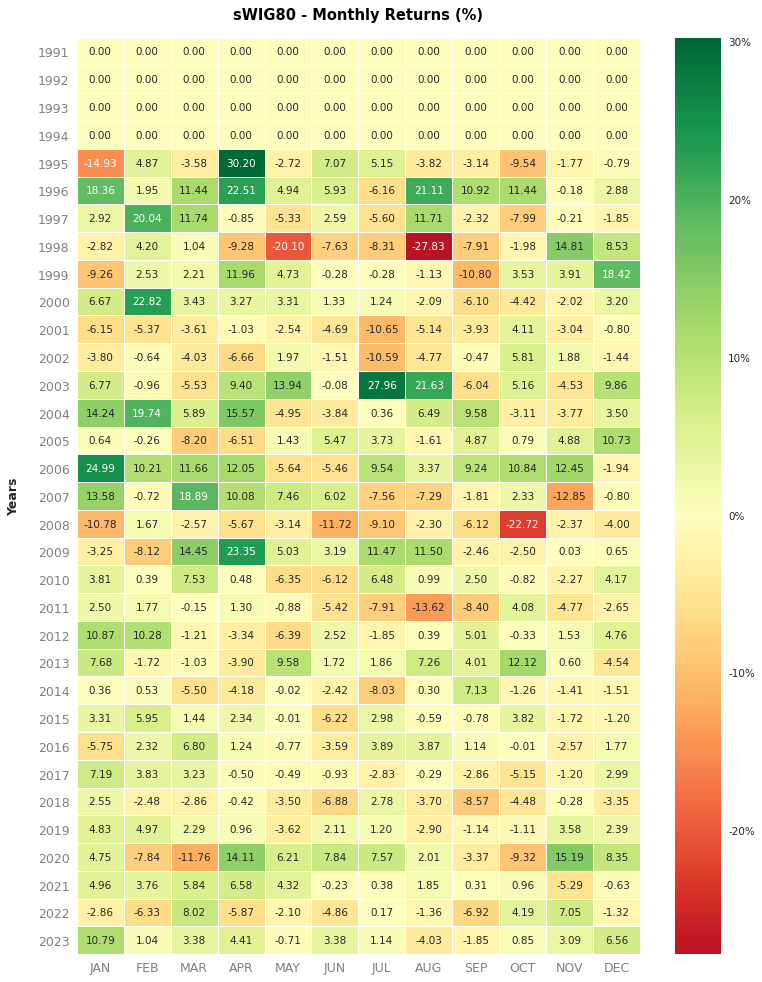

In [26]:
qs.plots.snapshot(df['close_swig80'], title='sWIG80 index performance', fontname='sans-serif')
qs.plots.drawdowns_periods(df['close_swig80'], title='sWIG80', fontname='sans-serif')
qs.plots.monthly_heatmap(df['close_swig80'], fontname='sans-serif', returns_label='sWIG80')

## Index level prediction (linear regression)

In [27]:
# Inspect columns of the combined DataFrame
df.columns

Index(['open_wig', 'high_wig', 'low_wig', 'close_wig', 'open_wig20',
       'high_wig20', 'low_wig20', 'close_wig20', 'open_mwig40', 'high_mwig40',
       'low_mwig40', 'close_mwig40', 'open_swig80', 'high_swig80',
       'low_swig80', 'close_swig80'],
      dtype='object')

In [28]:
# Drop unnecessary columns
df1 = df.drop(['open_wig', 
               'high_wig', 
               'low_wig', 
               'open_wig20', 
               'high_wig20', 
               'low_wig20', 
               'open_mwig40', 
               'high_mwig40', 
               'low_mwig40', 
               'open_swig80', 
               'high_swig80', 
               'low_swig80'], axis=1).copy()
df1.shape

(7732, 4)

In [29]:
# Create 5 lagged columns
df_lag = df1.copy()
lag = 5
for lag in range(1, lag + 1):
    shifted = df1.shift(lag)
    shifted.columns = [i + "_lag" + str(lag) for i in df1.columns]
    df_lag = pd.concat((df_lag, shifted), axis=1)
df_lag = df_lag.dropna()

In [30]:
# Check for reasonableness
df_lag.columns

Index(['close_wig', 'close_wig20', 'close_mwig40', 'close_swig80',
       'close_wig_lag1', 'close_wig20_lag1', 'close_mwig40_lag1',
       'close_swig80_lag1', 'close_wig_lag2', 'close_wig20_lag2',
       'close_mwig40_lag2', 'close_swig80_lag2', 'close_wig_lag3',
       'close_wig20_lag3', 'close_mwig40_lag3', 'close_swig80_lag3',
       'close_wig_lag4', 'close_wig20_lag4', 'close_mwig40_lag4',
       'close_swig80_lag4', 'close_wig_lag5', 'close_wig20_lag5',
       'close_mwig40_lag5', 'close_swig80_lag5'],
      dtype='object')

In [31]:
# Check: 4 indices + 5 lags each: 4+5*4 = 24 columns 
df_lag.shape

(6504, 24)

In [32]:
# Define target and predictors
target = df_lag[['close_wig', 'close_wig20', 'close_mwig40', 'close_swig80']]
predictors = df_lag[['close_wig_lag1', 'close_wig20_lag1', 'close_mwig40_lag1', 'close_swig80_lag1',
                     'close_wig_lag2', 'close_wig20_lag2', 'close_mwig40_lag2', 'close_swig80_lag2',
                     'close_wig_lag3', 'close_wig20_lag3', 'close_mwig40_lag3', 'close_swig80_lag3',
                     'close_wig_lag4', 'close_wig20_lag4', 'close_mwig40_lag4', 'close_swig80_lag4',
                     'close_wig_lag5', 'close_wig20_lag5', 'close_mwig40_lag5', 'close_swig80_lag5']]

In [33]:
# Sense check
df_lag.shape, target.shape, predictors.shape

((6504, 24), (6504, 4), (6504, 20))

In [34]:
# Perform linear regression (target = close, predictors = lagged close)
# Print the fitted regression parameters
lin_reg = np.linalg.lstsq(predictors[['close_wig_lag1', 'close_wig_lag2', 'close_wig_lag3', 'close_wig_lag4', 'close_wig_lag5']], target['close_wig'], rcond=None)[0]
lin_reg.round(2)

array([ 1.04, -0.07,  0.05, -0.03, -0.  ])

In [35]:
# Add the model's preds to the DataFrame
df_lag['pred'] = np.dot(predictors[['close_wig_lag1', 'close_wig_lag2', 'close_wig_lag3', 'close_wig_lag4', 'close_wig_lag5']], lin_reg)

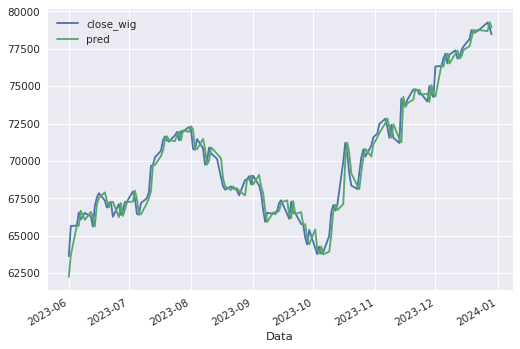

In [36]:
# Plot the index level vs the model predicted level
df_lag[['close_wig', 'pred']].loc['2023-06-01':].plot();

In [37]:
## Comment about liner regression assumptions NOT met...

## Index return prediction (linear regression)

In [38]:
# Create 5 lagged columns
df_lag = df1.copy()
lag = 5
for lag in range(1, lag + 1):
    shifted = df1.shift(lag)
    shifted.columns = [i + "_lag" + str(lag) for i in df1.columns]
    df_lag = pd.concat((df_lag, shifted), axis=1)
df_lag = df_lag.dropna()

In [39]:
# Calculate the daily log returns
# Drop the na value created in the process
df_lag['wig_r'] = np.log(df_lag['close_wig'] / df_lag['close_wig'].shift(1))
df_lag.dropna(inplace=True)
df_lag.columns

Index(['close_wig', 'close_wig20', 'close_mwig40', 'close_swig80',
       'close_wig_lag1', 'close_wig20_lag1', 'close_mwig40_lag1',
       'close_swig80_lag1', 'close_wig_lag2', 'close_wig20_lag2',
       'close_mwig40_lag2', 'close_swig80_lag2', 'close_wig_lag3',
       'close_wig20_lag3', 'close_mwig40_lag3', 'close_swig80_lag3',
       'close_wig_lag4', 'close_wig20_lag4', 'close_mwig40_lag4',
       'close_swig80_lag4', 'close_wig_lag5', 'close_wig20_lag5',
       'close_mwig40_lag5', 'close_swig80_lag5', 'wig_r'],
      dtype='object')

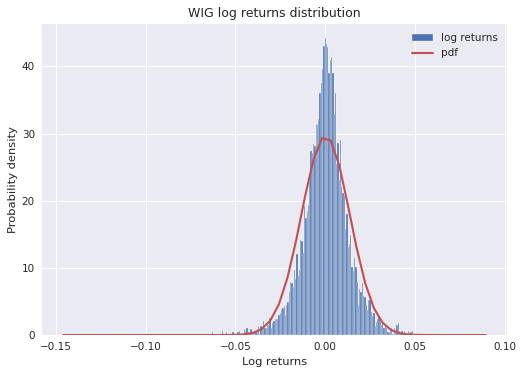

In [40]:
# Plot a histogram of daily log returns against a normal pdf curve
# The realized returns do not follow a normal distribution
plt.hist(df_lag['wig_r'], bins=300, density=True, label='log returns')
plt.xlabel('Log returns')
plt.ylabel('Probability density')
plt.title('WIG log returns distribution')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, df_lag['wig_r'].mean(), df_lag['wig_r'].std()), 'r', lw=2.0, label='pdf')
plt.legend();

In [41]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'wig_r_lag_{lag}'
    df_lag[col] = df_lag['wig_r'].shift(lag)
    cols.append(col)
df_lag.dropna(inplace=True)

In [42]:
df_lag.columns

Index(['close_wig', 'close_wig20', 'close_mwig40', 'close_swig80',
       'close_wig_lag1', 'close_wig20_lag1', 'close_mwig40_lag1',
       'close_swig80_lag1', 'close_wig_lag2', 'close_wig20_lag2',
       'close_mwig40_lag2', 'close_swig80_lag2', 'close_wig_lag3',
       'close_wig20_lag3', 'close_mwig40_lag3', 'close_swig80_lag3',
       'close_wig_lag4', 'close_wig20_lag4', 'close_mwig40_lag4',
       'close_swig80_lag4', 'close_wig_lag5', 'close_wig20_lag5',
       'close_mwig40_lag5', 'close_swig80_lag5', 'wig_r', 'wig_r_lag_1',
       'wig_r_lag_2', 'wig_r_lag_3', 'wig_r_lag_4', 'wig_r_lag_5'],
      dtype='object')

In [43]:
# Perform a linear regression (target = log daily return, predictors = lagged log daily returns)
# Print the fitted regression parameters
lin_reg = np.linalg.lstsq(df_lag[cols], df_lag['wig_r'], rcond=None)[0]
lin_reg.round(2)

array([ 0.08, -0.02,  0.01, -0.01,  0.01])

In [44]:
# Add the model's preds to the DataFrame
df_lag['pred'] = np.dot(df_lag[cols], lin_reg)

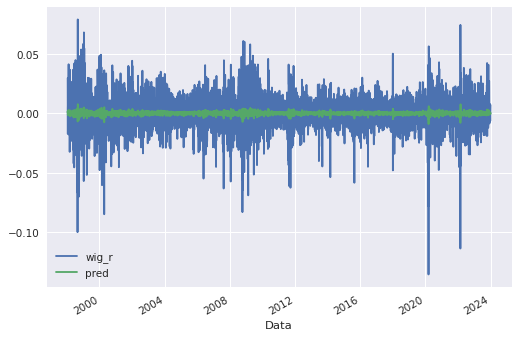

In [45]:
# Plot the index realized return vs the model predicted return
df_lag[['wig_r', 'pred']].plot();

In [46]:
# Calculate a 'hits' ratio (% of correct index direction preds)
hits = np.sign(df_lag['wig_r'] * df_lag['pred']).value_counts()
hits.values[0] / sum(hits)

0.5093875038473377

## Index direction prediction (linear regression)

In [47]:
df_lag = df1.copy()
lag = 5
for lag in range(1, lag + 1):
    shifted = df1.shift(lag)
    shifted.columns = [i + "_lag" + str(lag) for i in df1.columns]
    df_lag = pd.concat((df_lag, shifted), axis=1)
df_lag = df_lag.dropna()

In [48]:
df_lag['wig_r'] = np.log(df_lag['close_wig'] / df_lag['close_wig'].shift(1))
df_lag.dropna(inplace=True)

In [49]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'wig_r_lag_{lag}'
    df_lag[col] = df_lag['wig_r'].shift(lag)
    cols.append(col)
df_lag.dropna(inplace=True)

In [50]:
# Build a linear regression model (target = sign of log daily return, predictors = lagged log daily returns)
# Print the fitted regression parameters
lin_reg = np.linalg.lstsq(df_lag[cols], np.sign(df_lag['wig_r']), rcond=None)[0]
lin_reg.round(2)

array([ 2.13, -2.63, -0.64, -0.35,  0.78])

In [51]:
# Add the model's preds to the DataFrame
df_lag['pred'] = np.sign(np.dot(df_lag[cols], lin_reg))
df_lag['pred'].value_counts()

pred
-1.0    3370
 1.0    3128
Name: count, dtype: int64

In [52]:
# Calculate a 'hits' ratio (% of correct index direction preds)
hits = np.sign(df_lag['wig_r'] * df_lag['pred']).value_counts()
hits.values[0] / sum(hits)

0.5221606648199446

## Vectorized backtest

In [53]:
# Calculate the 'strategy return' - return realized if investing in the index based on the model's preds (no transaction costs) 
df_lag['strategy_r'] = df_lag['pred'] * df_lag['wig_r']
df_lag[['wig_r', 'strategy_r']].sum().apply(np.exp)

wig_r           5.753205
strategy_r    116.029776
dtype: float64

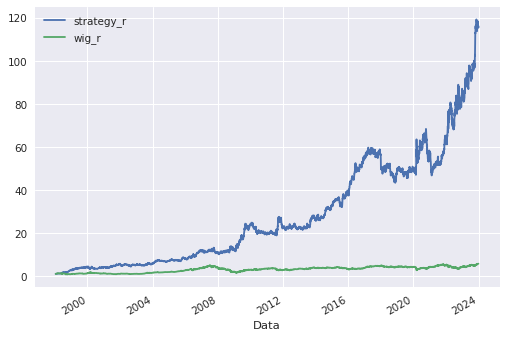

In [54]:
# Plot cumulative returns of the strategy vs the index return
df_lag[['strategy_r', 'wig_r',]].dropna().cumsum().apply(np.exp).plot();

## Index direction prediction (logistic regression)

In [55]:
df_lag = df1.copy()
lag = 5
for lag in range(1, lag + 1):
    shifted = df1.shift(lag)
    shifted.columns = [i + "_lag" + str(lag) for i in df1.columns]
    df_lag = pd.concat((df_lag, shifted), axis=1)
df_lag = df_lag.dropna()

In [56]:
df_lag['wig_r'] = np.log(df_lag['close_wig'] / df_lag['close_wig'].shift(1))
df_lag.dropna(inplace=True)

In [57]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'wig_r_lag_{lag}'
    df_lag[col] = df_lag['wig_r'].shift(lag)
    cols.append(col)
df_lag.dropna(inplace=True)

In [58]:
# Instantiate a logistic regression model (large C value for no regularization,....)
log_reg = linear_model.LogisticRegression(C=1e7, solver='lbfgs', multi_class='auto', max_iter=1000)

In [59]:
# Perform a logistic regression (target = log daily return, predictors = lagged log daily returns)
log_reg.fit(df_lag[cols], np.sign(df_lag['wig_r']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [60]:
# Add the model's preds to the DataFrame
df_lag['pred'] = log_reg.predict(df_lag[cols])
df_lag['pred'].value_counts()

pred
 1.0    5545
-1.0     953
Name: count, dtype: int64

In [61]:
# Calculate a 'hits' ratio (% of correct index direction preds)
hits = np.sign(df_lag['wig_r'] * df_lag['pred']).value_counts()
hits

 1.0    3392
-1.0    3105
 0.0       1
Name: count, dtype: int64

In [62]:
# Calculate accuracy_score metric
accuracy_score(df_lag['pred'], np.sign(df_lag['wig_r']))

0.5220067713142506

In [63]:
# Calculate the 'strategy return' - return realized if investing in the index based on the model's preds (no transaction costs) 
df_lag['strategy_r'] = df_lag['pred'] * df_lag['wig_r']
df_lag[['strategy_r', 'wig_r']].sum().apply(np.exp)

strategy_r    26.902410
wig_r          5.753205
dtype: float64

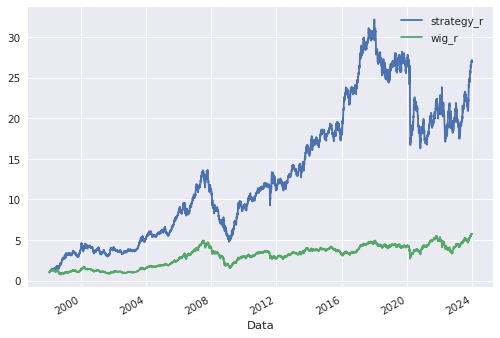

In [64]:
# Plot a cumulative returns of the strategy vs the index
df_lag[['strategy_r', 'wig_r']].dropna().cumsum().apply(np.exp).plot();

## Index direction prediction (DNNs)

In [65]:
df_lag = df1.copy()
lag = 5
for lag in range(1, lag + 1):
    shifted = df1.shift(lag)
    shifted.columns = [i + "_lag" + str(lag) for i in df1.columns]
    df_lag = pd.concat((df_lag, shifted), axis=1)
df_lag = df_lag.dropna()

In [66]:
df_lag['wig_r'] = np.log(df_lag['close_wig'] / df_lag['close_wig'].shift(1))
df_lag.dropna(inplace=True)

In [67]:
# Convert daily log returns into 0 (negative return) or 1 (positive return) 
df_lag['dir'] = np.where(df_lag['wig_r'] > 0, 1, 0)

In [68]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'wig_r_lag_{lag}'
    df_lag[col] = df_lag['wig_r'].shift(lag)
    cols.append(col)
df_lag.dropna(inplace=True)
df_lag.shape

(6498, 31)

In [69]:
# Perform a train/val/test split, set shuffle to false
# 80% training
# 20% testing 
# 10% validation
x_train, x_test, y_train, y_test = train_test_split(df_lag, df_lag, test_size=0.2, random_state=100, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=100, shuffle=False)

print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Shape of x_val: ", x_val.shape)
print("Shape of y_val: ", y_val.shape)

Shape of x_train:  (4678, 31)
Shape of y_train:  (4678, 31)
Shape of x_test:  (1300, 31)
Shape of y_test:  (1300, 31)
Shape of x_val:  (520, 31)
Shape of y_val:  (520, 31)


In [70]:
print(len(x_train) + len(x_val) + len(x_test))
print(len(y_train) + len(y_val) + len(y_test))

6498
6498


## A DNN model

In [71]:
set_seeds()
model = Sequential()
model.add(Dense(8, activation="relu", input_shape=(len(cols),)))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

In [72]:
model.fit(x_train[cols], x_train['dir'], epochs = 25, verbose=False, shuffle=False)

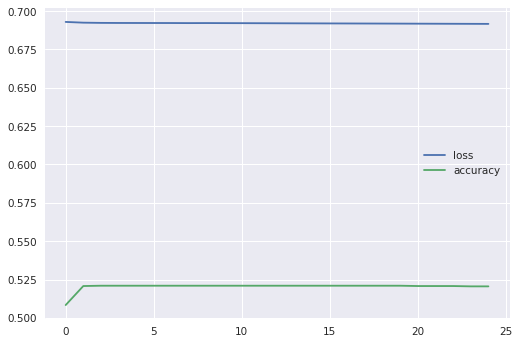

In [73]:
# Plot learning curves
res = pd.DataFrame(model.history.history)
res[['loss', 'accuracy']].plot();

In [74]:
model.evaluate(x_train[cols], x_train['dir'])

147/147 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5209


[0.691490650177002, 0.520949125289917]

147/147 [==============================] - 0s 2ms/step


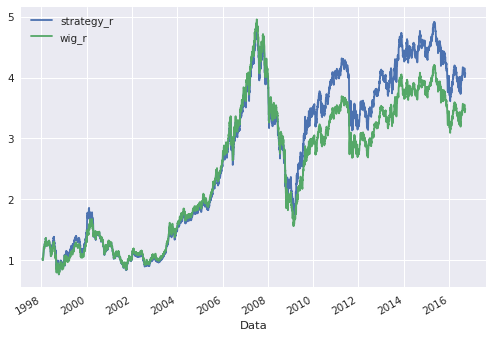

In [75]:
pred = np.where(model.predict(x_train[cols]) > 0.5, 1, 0)
x_train['pred'] = np.where(pred > 0, 1, -1)
x_train['strategy_r'] = (x_train['pred'] * x_train['wig_r'])
x_train[['strategy_r', 'wig_r']].cumsum().apply(np.exp).plot();

In [76]:
test_scores = model.evaluate(x_test[cols], x_test['dir'], verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

41/41 - 0s - loss: 0.6928 - accuracy: 0.5162 - 78ms/epoch - 2ms/step
Test loss: 0.6927697658538818
Test accuracy: 0.516153872013092


In [77]:
pred = np.where(model.predict(x_test[cols]) > 0.5, 1, 0)
x_test['pred'] = np.where(pred > 0, 1, -1)
x_test['pred'].value_counts()

41/41 [==============================] - 0s 1ms/step


pred
 1    1298
-1       2
Name: count, dtype: int64

In [78]:
x_test['strategy_r'] = (x_test['pred'] * x_test['wig_r'])
x_test[['strategy_r', 'wig_r']].sum().apply(np.exp)

strategy_r    1.500351
wig_r         1.372728
dtype: float64

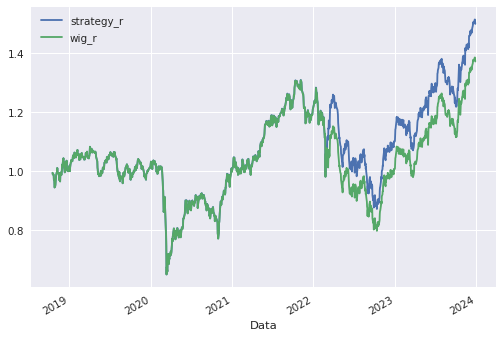

In [79]:
x_test[['strategy_r', 'wig_r', ]].cumsum().apply(np.exp).plot();

## A DNN model (more features)

In [80]:
# Let's add some additional features
df_lag['mom'] = df_lag['wig_r'].rolling(5).mean().shift(1)
df_lag['vol'] = df_lag['wig_r'].rolling(20).std().shift(1)
df_lag['dis'] = (df_lag['close_wig'] - df_lag['close_wig'].rolling(50).mean()).shift(1)
df_lag.dropna(inplace=True)
cols.extend(['mom', 'vol', 'dis'])

In [81]:
x_train, x_test, y_train, y_test = train_test_split(df_lag, df_lag, test_size=0.2, random_state=100, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=100, shuffle=False)

In [82]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation="relu", input_shape=(len(cols),)))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

In [83]:
model.fit(x_train[cols], x_train['dir'], epochs = 50, verbose=False, shuffle=False)

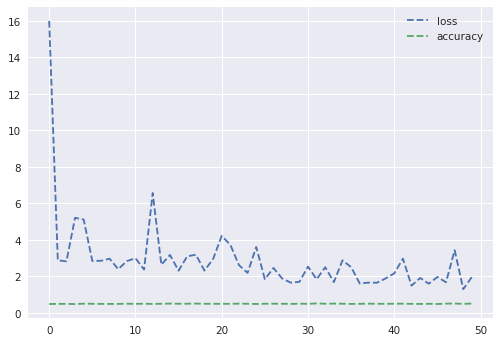

In [84]:
res = pd.DataFrame(model.history.history)
res[['loss', 'accuracy']].plot(style='--');

In [85]:
model.evaluate(x_train[cols], x_train['dir'])

146/146 [==============================] - 0s 2ms/step - loss: 2.6087 - accuracy: 0.5002


[2.608665943145752, 0.5002154111862183]

146/146 [==============================] - 0s 2ms/step


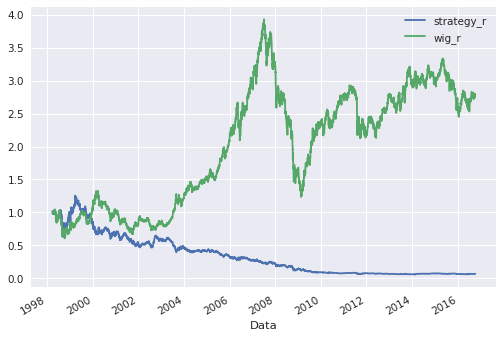

In [86]:
pred = np.where(model.predict(x_train[cols]) > 0.5, 1, 0)
x_train['pred'] = np.where(pred > 0, 1, -1)
x_train['strategy_r'] = (x_train['pred'] * x_train['wig_r'])
x_train[['strategy_r', 'wig_r', ]].cumsum().apply(np.exp).plot();

In [87]:
test_scores = model.evaluate(x_test[cols], x_test['dir'], verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

41/41 - 0s - loss: 4.8396 - accuracy: 0.4837 - 102ms/epoch - 2ms/step
Test loss: 4.839567184448242
Test accuracy: 0.48372092843055725


In [88]:
pred = np.where(model.predict(x_test[cols]) > 0.5, 1, 0)
x_test['pred'] = np.where(pred > 0, 1, -1)
x_test['pred'].value_counts()

41/41 [==============================] - 0s 2ms/step


pred
-1    782
 1    508
Name: count, dtype: int64

In [89]:
x_test['strategy_r'] = (x_test['pred'] * x_test['wig_r'])
x_test[['strategy_r', 'wig_r', ]].sum().apply(np.exp)

strategy_r    0.422195
wig_r         1.436764
dtype: float64

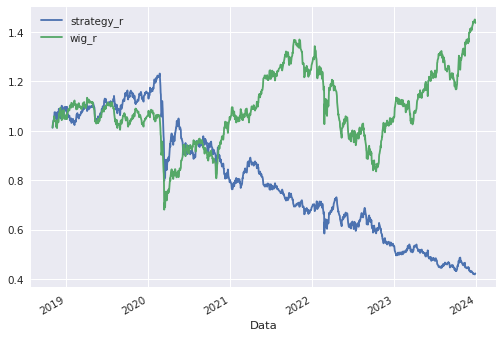

In [90]:
x_test[['strategy_r', 'wig_r']].cumsum().apply(np.exp).plot();